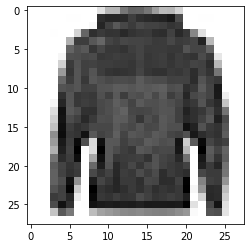

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
x = np.load("fashion_mnist_images.npy")
y = np.load("fashion_mnist_labels.npy")
d, n= x.shape

i = 0 #Index of the image to be visualized 
plt.imshow(np.reshape(x[:,i], (int(np.sqrt(d)),int(np.sqrt(d)))), cmap="Greys")
plt.show()

In [2]:
# Helper for sigmoid function
def sig(z):
    return 1 / (1 + np.exp(-z))

In [3]:
# Sigmoid function
def sigmoid(x_i, y_i, theta):
    z = y_i * np.dot(theta.T, x_i)
    return 1/(1.0 + np.exp(-z))

In [4]:
# Log-likelihood function for logistic regression
# Set the initial values of lambda as 1
def log_likelihood(x, y, theta, lmda = 1): 
    # Compute the sum of the -l(theta)
    sum = 0
    for i in range(n):
        x_i = np.insert(x[:, i].reshape(d, 1), 0, 1, axis = 0)
        sig_prob = sigmoid(x_i, y[0][i], theta)
        sum += -np.log(sig_prob)

    # Add the regularization term to the sum
    J = sum + lmda * np.sum(theta[1:] ** 2)
    return J

In [5]:
# Gradient of the log-likelihood
def gradient(x, y, theta):
    # initialize the gradient as a (d+1) x 1 vector
    grad = np.zeros([d+1, 1])
    for i in range(n):
        x_i = np.insert(x[:, i].reshape(d, 1), 0, 1, axis = 0)
        sig_prob = sigmoid(x_i, y[0][i], theta)
        grad += (sig_prob - 1) * y[0][i] * x_i
    return grad + 2 * theta # Add the gradient of the regularization term back to the gradient

In [6]:
# Hessian of the log-likelihood
def hessian(x, y, theta):
    # initialize the hessian
    h = np.zeros([d+1, d+1])
    for i in range(n):
        x_i = np.insert(x[:, i].reshape(d, 1), 0, 1, axis = 0) # Change each X_i to a d+1 x 1 vector by add one to the first entry
        sig_prob = sigmoid(x_i, y[0][i], theta)
        h += sig_prob * (1 - sig_prob) * np.dot(x_i, x_i.T)
    return h + 2 * np.eye(d+1) # The second derivative of the regularization term

In [7]:
# Newton's method for logistic regression when the label is {-1, 1}
def newtons_method(x, y, lambda_, epsilon):
    # initialize all the required parameters for newtons method
    theta = np.zeros([d+1, 1])
    J_history = log_likelihood(x, y, theta)

    # The difference between J_history and J-new
    # initialize it as infinite so that the loop can start
    delta_J = np.inf
    iteration = 0 # Record the number of iterations

    # The loop to check the convergence
    while abs(delta_J)/J_history > epsilon:
        # Compute the gradient and Hessian
        g = gradient(x, y, theta)
        h = hessian(x, y, theta)

        # Newton-Raphson update
        H_inverse = np.linalg.inv(h)
        delta = H_inverse.dot(g)
        theta -= delta

        # Compute new J(theta) with the updated theta
        J_new = log_likelihood(x, y, theta)
        # Update the difference
        delta_J = J_history - J_new 
        # Record last J(theta)
        J_history = J_new
        iteration += 1

    # Return the optimal theta, J(theta_opt), and number of iterations
    return theta, J_history, iteration 

In [8]:
# Split dataset into training data (first 5000) and testing (last 1000)
x_train, x_test = x[:, :5000], x[:, 5000:]
y_train, y_test = y[:, :5000], y[:, 5000:]

# Update d and n to record the new dimensions and number of data
d, n = x_train.shape
# Regularization parameter
lambda_ = 1
# Convergence threshold
epsilon = 1e-6

# Train model using Newton's Method
theta_opt, J_history, num_iterations = newtons_method(x_train, y_train, lambda_, epsilon)

In [9]:
# Change the test set to d+1 dimensions
x_test = np.insert(x_test, 0, 1, axis = 0)
# Test model on test data
y_pred = np.where(sig(np.dot(theta_opt.T, x_test)) >= 0.5, 1, -1)
test_error = np.mean((y_test - y_pred) ** 2)

# Report results
print(f"Test error: {test_error}")
print(f"Number of iterations: {num_iterations}")
print(f"Final objective value: {J_history}")

Test error: 0.136
Number of iterations: 9
Final objective value: [[452.30858258]]


### Confidence
Confidence refers to how confident the model is in its predictions. Here, I use the absolute value of difference between $p(y=1|x)=\frac{1}{1+e^{-\theta^{T}x}}$ and $\frac{1}{2}$ to represent confidence. If the probability of the prediction is close to $\frac{1}{2}$, it implies the model is not confident about making this prediction. Therefore, the difference is suitable for measuring confidence.

In [10]:
# Compute the confidence of test data according to the notion above
y_conf = sig(np.dot(theta_opt.T, x_test))
confidence = np.abs(y_conf - 0.5)

# The misclassified data is where the prediction is not aligned with the test data
misclassified_indices = np.where(y_pred != y_test)[1]

# Get the indices of the 20 least confident data
least_confident_indices = misclassified_indices[np.argsort(confidence[0][misclassified_indices])][:20]

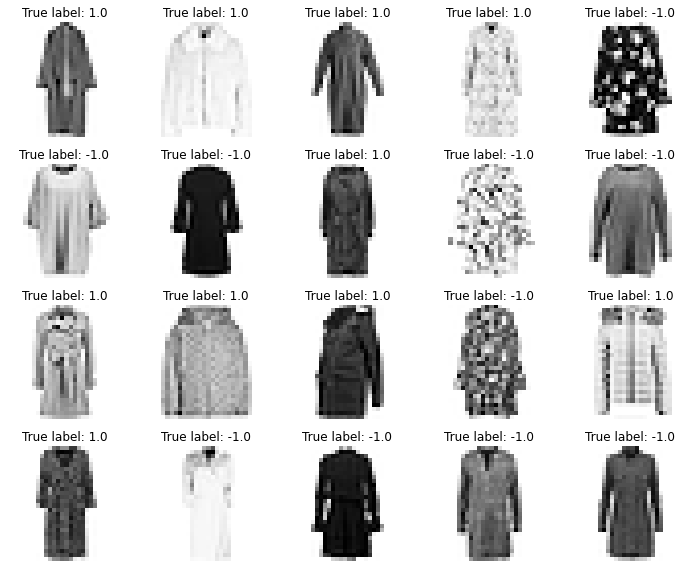

In [11]:
# Visualize least confident misclassified images
plt.figure(figsize=(10, 8))
for i, idx in enumerate(least_confident_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.reshape(x_test[1:, idx], (28, 28)), cmap="Greys")
    plt.title(f"True label: {y_test[0][idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()